# Percolational regions as a polycentricity measure

In [1]:
import json
import os
import pandas as pd
import geopandas as gpd
import numpy as npa
from sklearn.cluster import DBSCAN

In [2]:
os.chdir('D:/bachelors/datasets/')

# Preparation

In [3]:
with open('Variables/mappers/communes_names_map.json') as infile:
    names_map = json.load(infile)

In [4]:
nodes_path = 'analysis/yearly_graphs_v4/total/nodes_total_{}.csv'
datatables_path = 'translated_data_v4/data_{}.csv'

In [5]:
def read_raw_data(datatable_path):
    df_current = pd.read_csv(datatable_path)
#     df_current['geo_departure'], df_current['geo_arrival'] = df_current['geo_departure'].map(names_map), df_current['geo_arrival'].map(names_map)
    df_current.dropna(subset = ['geo_departure', 'geo_arrival'], inplace = True)
#     df_current = df_current[df_current.geo_departure != df_current.geo_arrival]
    df_current = pd.pivot_table(df_current, 'uid_person', 'geo_departure', 'geo_arrival', aggfunc = 'nunique')
    df_current.values[[np.arange(df_current.shape[0])]*2] = 0
    maxim = np.max(df_current.fillna(0).values)
    df_current = ((df_current / maxim) * -1 + 1).fillna(1)
    
    return df_current

## Create a list of epsilon values to cluster

In [6]:
epses = [float(i[:4]) for i in np.arange(0.1, 1.01, 0.01).astype(str).tolist()] 

In [7]:
epses = [i/100 for i in range(1, 101)]

## Plot tools

In [8]:
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import matplotlib

medium_font = fm.FontProperties(fname =  "D:/bachelors/datasets/viz/Roboto-Medium.ttf", size = 12)
regluar_font = fm.FontProperties(fname = "D:/bachelors/datasets/viz/Roboto-Regular.ttf", size = 12)

colors = {
    'peach' : '#FCB886',
    'blue' : '#6FC7F7',
    'green' : '#78AF34',
    'red' : '#D25B5B',
    'grey' : '#8B8B8B'
}

In [9]:
def model_regions(dat):
    """Builds hierarchy of regions for a distance matrix"""
    series_list = []
    for eps in epses:
        labs = DBSCAN(eps = eps, min_samples = 2, metric = 'precomputed').fit(dat).labels_
        series_list.append(pd.Series(labs, dat.index).rename(f'percolation_{eps}'))
    percolation_classes = pd.DataFrame(series_list).transpose()
    percolation_classes = percolation_classes.applymap(lambda elem: None if elem == -1 else elem)
    return percolation_classes

In [10]:
def map_series(series):
    if series.name in dict_perc_reg.keys():
        return series.map(dict_perc_reg[series.name])
    else:
        return series

In [11]:
with open('Variables/mappers/communes_names_toRussian_map.json') as infile:
    rus_names = json.load(infile)

In [12]:
import seaborn as sns

In [13]:
def plot_percolation(matrix, year):
    plt.figure(figsize = (11,11))

    ax = sns.heatmap(matrix,
                     linewidths = .3,
                     zorder = 1,
                     cmap = 'viridis',
                     cbar = False)
    plt.grid(ls = ':', zorder = 0)
    plt.xticks(fontproperties = regluar_font)

    plt.yticks(fontproperties = regluar_font)
    ax.set_title(f'{year}', loc = 'left', fontproperties = medium_font, fontsize=24)
    ax.set_xlabel('Фильтр интенсивности поездок', fontproperties = medium_font, fontsize=18)
    ax.set_ylabel('Главный муниципалитет кластера', fontproperties = medium_font, fontsize=18)
    plt.tight_layout()
    plt.savefig(f'analysis/percolation_regions/plots_v4/{year}_percolation.png')
    plt.close('all')

In [14]:
import math

def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier

In [15]:
bounds = gpd.read_file('../qgis/base/Netherlands_communes.gpkg')

In [16]:
from collections import defaultdict

In [17]:
def percolation_regions_resample(percolation_classes, year):
    df = percolation_classes.drop(columns = ['flow_cent']).stack().reset_index().rename(columns = {
        'commune' : 'NAME',
        'level_1' : 'percolation_threshold',
        0 : 'parent'
    }).assign(
        year = year
    )
    
    return df

In [18]:
sustain = []
regions_cores_list = []
region_to_core_map = defaultdict(dict)
percolation_regions = []
for year in range(2004,2018):
    dat = read_raw_data(datatables_path.format(year))
    nodes = pd.read_csv(nodes_path.format(year))
    
    percolation_classes = model_regions(dat)
    percolation_classes = percolation_classes.reset_index().merge(nodes[['commune', 'flow_cent']], left_on = 'geo_departure', right_on = 'commune', how = 'left').drop(columns = ['geo_departure'])
    dict_perc_reg = {
        f'percolation_{eps}' : percolation_classes.set_index(
            'commune'
        ).groupby(
            f'percolation_{eps}'
        )['flow_cent'].idxmax().to_dict() for eps in epses
    }
    percolation_classes = percolation_classes.apply(map_series).apply(
        lambda x: x.map(rus_names) if x.name not in ['commune', 'flow_cent'] else x
    )

    matrix = percolation_classes.drop(columns = ['flow_cent', 'commune']).apply(lambda column: column.value_counts())
    percolation_classes = percolation_classes.set_index('commune')
    percolation_regions.append(percolation_regions_resample(percolation_classes, year))
    matrix.columns = [float(i.split('_')[1]) for i in matrix.columns]
    matrix = matrix.sort_values(by = list(matrix.columns))
    first_value = matrix.dropna(axis=1, how = 'all').columns[0]
    matrix = matrix.loc[:, round_down(first_value, 1):]
#     break
    matrix = matrix.assign(
        order = matrix.apply(lambda row: row.loc[row == row.dropna().iloc[0]].index[0], axis = 'columns'),
        parent = matrix.apply(
            lambda row: round(row.loc[row == row.dropna().iloc[-1]].index[0] + .01, 2) if \
            row.loc[row == row.dropna().iloc[-1]].index[0] < 1 else 1,
            axis = 'columns'),
        duration = matrix.apply(lambda x: x.isnull().sum(), axis='columns')
    )







#     matrix['order'] = matrix.apply(lambda row: row.loc[row == row.dropna().iloc[0]].index[0], axis = 'columns')
#     matrix['duration'] = matrix.apply(lambda x: x.isnull().sum(), axis='columns')
#     matrix['parent'] = matrix.apply(lambda row: row.loc[row == row.dropna().iloc[-1]].index[0] + .01, axis = 'columns')
    matrix = matrix.sort_values(by = ['order', 'duration'])
    plot_percolation(matrix.drop(columns = ['order', 'duration', 'parent']), year)
    
    cutpoint_core = matrix['order'].to_dict()
    parent_core = matrix['parent'].to_dict()
    matrix.drop(columns = ['order', 'parent', 'duration'], inplace = True)
#     break
    sustain.append(len(matrix.columns) - matrix.isna().sum(axis = 'columns').mean())
    regions_cores = {}
    for name, cpt in cutpoint_core.items():
        regions_cores.update(
            percolation_classes[percolation_classes[f'percolation_{cpt}'] == name][f'percolation_{cpt}'].to_dict()
        )
        
    parent_cores = {}
    for name, cpt in parent_core.items():
        parent_cores.update(
            percolation_classes[percolation_classes[f'percolation_{cpt}'] == name][f'percolation_{cpt}'].to_dict()
        )

    
    sustainability = percolation_classes.drop(columns = ['flow_cent']).apply(
        lambda x: x.value_counts(), axis = 'rows'
    ).dropna(how = 'all').dropna(axis = 'columns', how = 'all')
    sustainability['sust'] = sustainability.apply(lambda x: sustainability.shape[1] - x.isnull().sum(), axis='columns')
    
    bounds['parent'] = bounds['NAME'].map(regions_cores)
    bounds['sustain'] = bounds['parent'].map(sustainability['sust'].to_dict())
    bounds.to_file(f'analysis/percolation_regions/{year} region cores sustain_v2.gpkg', driver = 'GPKG')
    
    region_to_core_map[str(year)] = regions_cores    
    regions_cores_list.append(bounds.assign(core = lambda frame: frame.NAME.map(regions_cores), 
                                            year = year))

C:\Users\mtopn\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2004 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2004 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'
C:\Users\mtopn\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2005 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2005 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'
C:\Users\mtopn\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2006 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2006 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'
C:\Users\mtopn\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2007 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2007 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'
C:\Users\mtopn\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2008 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2008 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'
C:\Users\mtopn\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2009 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2009 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'
C:\Users\mtopn\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2010 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2010 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'
C:\Users\mtopn\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2011 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2011 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'
C:\Users\mtopn\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2012 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2012 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'
C:\Users\mtopn\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2013 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2013 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'
C:\Users\mtopn\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2014 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2014 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'
C:\Users\mtopn\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2015 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2015 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'
C:\Users\mtopn\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2016 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2016 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'
C:\Users\mtopn\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2017 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2017 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


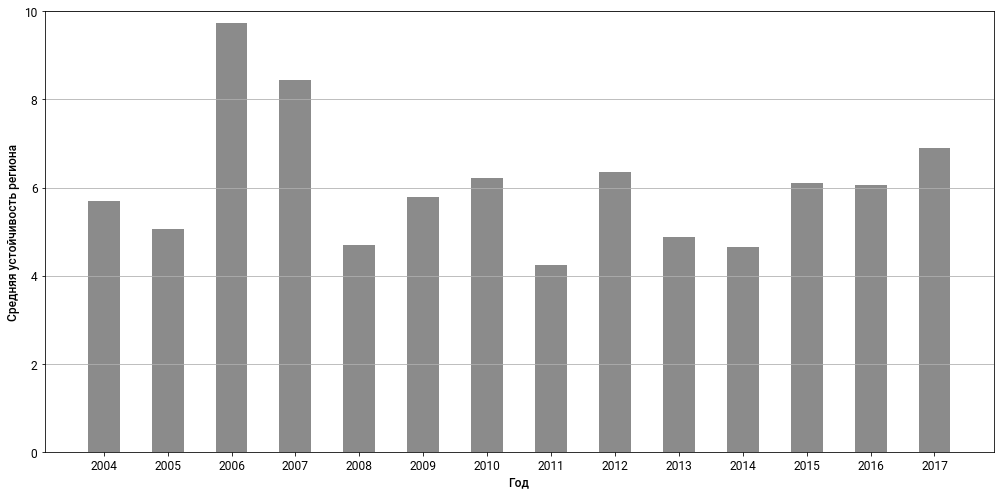

In [19]:
plt.figure(figsize = (14,7), facecolor = 'w')

plt.bar([i for i in range(2004, 2018)], sustain, width=.5, color = colors['grey'])
plt.xticks([i for i in range(2004, 2018)], [i for i in range(2004, 2018)], fontproperties = regluar_font)
plt.yticks(fontproperties = regluar_font)
plt.grid(axis = 'y')
plt.ylim(0,10)
plt.ylabel('Средняя устойчивость региона',  fontproperties = medium_font)
plt.xlabel('Год', fontproperties = medium_font)
plt.tight_layout()
plt.savefig('analysis/percolation_regions/plots_v4/Mean Sustainability.png')
# plt.yticks([i for i in range(len(sustain))], [i for i in range(2004, 2018)])

In [20]:
df_list = {year : gpd.read_file(f'analysis/percolation_regions/{year} region cores sustain_v2.gpkg') for year in range(2004,2018)}

In [21]:
[
    df_list[year].dropna(
        subset = ['parent']
    ).dissolve(by = 'parent').reset_index().to_file(
        f'analysis/percolation_regions/{year} region cores sustain_v2.gpkg'
    ) for year in range(2004,2018)
]

CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2004 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2004 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2005 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2005 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2006 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2006 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2007 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2007 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2008 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2008 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2009 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2009 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2010 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2010 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2011 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2011 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2012 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2012 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2013 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2013 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2014 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2014 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2015 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2015 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2016 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2016 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2017 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2017 region cores sustain_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [22]:
[
    bounds.drop(
        columns = ['parent', 'sustain']
    ).merge(
        i, on = 'NAME', how = 'right'
    ).dropna(subset = ['geometry']).dissolve(by = ['parent','percolation_threshold']).reset_index().to_file(
        f'analysis/percolation_regions/evo/{i.year.unique()[0]}_evolution_v2.gpkg',
        driver = 'GPKG'
    ) for i in percolation_regions
]

CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2004_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2004_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2005_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2005_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2006_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2006_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2007_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2007_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2008_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2008_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2009_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2009_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2010_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2010_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2011_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2011_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2012_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2012_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2013_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2013_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2014_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2014_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2015_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2015_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2016_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2016_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2017_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2017_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [23]:
[
    bounds.drop(
        columns = ['parent', 'sustain']
    ).merge(
        i, on = 'NAME', how = 'right'
    ).dropna(subset = ['geometry']).dissolve(by = ['parent','percolation_threshold']).reset_index().to_file(
        f'analysis/percolation_regions/evo/{i.year.unique()[0]}_evolution_v2.gpkg',
        driver = 'GPKG'
    ) for i in percolation_regions
]

CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2004_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2004_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2005_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2005_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2006_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2006_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2007_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2007_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2008_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2008_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2009_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2009_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2010_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2010_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2011_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2011_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2012_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2012_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2013_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2013_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2014_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2014_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2015_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2015_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2016_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2016_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2017_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_2017_evolution_v2_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [94]:
pd.Series([f'percolation_{eps}' for eps in epses]).rename('percolation_threshold').to_csv('analysis/percolation_regions/evo/Atlas.csv')

C:\Users\mtopn\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
